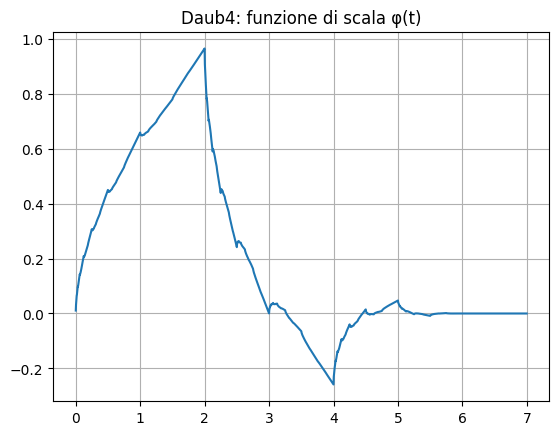

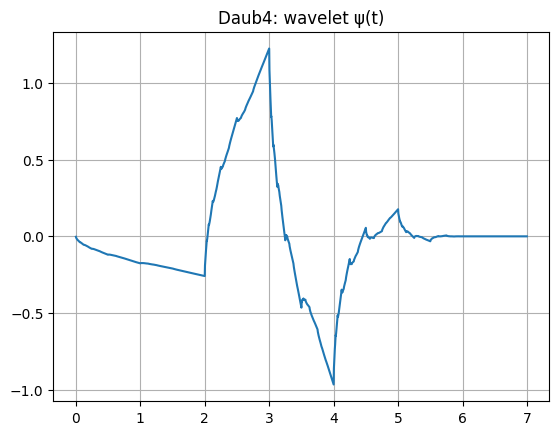

=== Ortogonalità (approssimata) ===

<phi, phi(t-k)> (atteso ~1 per k=0, ~0 altrove)
  k=-5: +0.000000
  k=-4: -0.000000
  k=-3: -0.062500
  k=-2: +0.000000
  k=-1: +0.562500
  k= 0: +1.000000
  k= 1: +0.562500
  k= 2: +0.000000
  k= 3: -0.062500
  k= 4: -0.000000
  k= 5: +0.000000

<psi, psi(t-k)> (atteso ~1 per k=0, ~0 altrove)
  k=-5: -0.000000
  k=-4: +0.000000
  k=-3: +0.062500
  k=-2: -0.000000
  k=-1: -0.562500
  k= 0: +1.000000
  k= 1: -0.562500
  k= 2: -0.000000
  k= 3: +0.062500
  k= 4: +0.000000
  k= 5: -0.000000

<phi, psi(t-k)> (atteso ~0)
  k=-5: +0.000000
  k=-4: -0.000000
  k=-3: -0.233253
  k=-2: +0.000000
  k=-1: +0.483253
  k= 0: -0.000000
  k= 1: -0.266747
  k= 2: -0.000000
  k= 3: +0.016747
  k= 4: +0.000000
  k= 5: -0.000000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# =========================
#  Filtri Daubechies-4
# =========================
def daub4_filters():
    """
    Daubechies-4 (lunghezza 4). Convenzione:
      cs = low-pass (scaling)
      cw = high-pass (wavelet) ottenuto via QMF: g[n] = (-1)^n h[L-1-n]
    """
    s3 = np.sqrt(3.0)
    cs = np.array([1 + s3, 3 + s3, 3 - s3, 1 - s3], dtype=float) / (4.0 * np.sqrt(2.0))
    L = len(cs)
    cw = np.array([((-1) ** n) * cs[L - 1 - n] for n in range(L)], dtype=float)
    return cs, cw


# =========================
#  Utility
# =========================
def dyadup(x):
    """Upsampling di fattore 2 inserendo zeri: [x0,0,x1,0,...]."""
    y = np.zeros(2 * len(x), dtype=float)
    y[0::2] = np.asarray(x, dtype=float).ravel()
    return y


def l2_normalize(x, dt):
    nrm = np.sqrt(np.sum(x**2) * dt)
    return x / nrm if nrm > 0 else x


# =========================
#  Cascade (stile MATLAB)
# =========================
def cascade(n, cs, cw, normalize_l2=True):
    """
    Implementazione fedele allo stile MATLAB del laboratorio:
      - seed: s=cs, w=cw
      - iterazioni: upsample -> conv con cs
    Ritorna: s(phi), w(psi), assi t_s e t_w (possono avere lunghezze diverse), dt.
    """
    s = np.asarray(cs, dtype=float).ravel()
    w = np.asarray(cw, dtype=float).ravel()

    dt = 1.0
    for _ in range(n):
        # upsample => dt dimezza
        s_u = dyadup(s)
        w_u = dyadup(w)
        dt *= 0.5

        # conv con cs
        s = np.convolve(s_u, cs, mode="full")
        w = np.convolve(w_u, cs, mode="full")

    if normalize_l2:
        s = l2_normalize(s, dt)
        w = l2_normalize(w, dt)

    t_s = np.arange(len(s)) * dt
    t_w = np.arange(len(w)) * dt
    return s, w, t_s, t_w, dt


# =========================
#  Verifica ortogonalità
# =========================
def inner_product_shift_samples(a, b, shift_samples, dt):
    """<a(t), b(t-shift)> approssimato su griglia uniforme."""
    if shift_samples > 0:
        a1 = a[shift_samples:]
        b1 = b[:-shift_samples]
    elif shift_samples < 0:
        k = -shift_samples
        a1 = a[:-k]
        b1 = b[k:]
    else:
        a1, b1 = a, b
    if len(a1) == 0 or len(b1) == 0:
        return 0.0
    return float(np.dot(a1, b1) * dt)


def check_orthogonality(phi, psi, n, dt, max_k=5):
    """
    Controllo classico su shift interi k:
      shift 1 nel continuo => 2^n campioni (perché dt=2^-n).
    """
    step = 2**n
    print("=== Ortogonalità (approssimata) ===")
    print("\n<phi, phi(t-k)> (atteso ~1 per k=0, ~0 altrove)")
    for k in range(-max_k, max_k + 1):
        sh = k * step
        print(f"  k={k:2d}: {inner_product_shift_samples(phi, phi, sh, dt):+.6f}")

    print("\n<psi, psi(t-k)> (atteso ~1 per k=0, ~0 altrove)")
    for k in range(-max_k, max_k + 1):
        sh = k * step
        print(f"  k={k:2d}: {inner_product_shift_samples(psi, psi, sh, dt):+.6f}")

    print("\n<phi, psi(t-k)> (atteso ~0)")
    for k in range(-max_k, max_k + 1):
        sh = k * step
        print(f"  k={k:2d}: {inner_product_shift_samples(phi, psi, sh, dt):+.6f}")


# =========================
#  MAIN
# =========================
if __name__ == "__main__":
    cs, cw = daub4_filters()

    print()

    n = 10

    phi, psi, t_phi, t_psi, dt = cascade(n, cs, cw, normalize_l2=True)

    plt.figure(); plt.plot(t_phi, phi); plt.title("Daub4: funzione di scala φ(t)"); plt.grid(True)
    plt.figure(); plt.plot(t_psi, psi); plt.title("Daub4: wavelet ψ(t)"); plt.grid(True)
    plt.show()

    check_orthogonality(phi, psi, n=n, dt=dt, max_k=5)

=== Biortogonalità (con tempi reali) ===

<phi(t-k), phi~(t)>
  k=-5: +0.023705
  k=-4: +0.000000
  k=-3: -0.118523
  k=-2: +0.000000
  k=-1: +0.592615
  k= 0: +0.990755
  k= 1: +0.592615
  k= 2: +0.000000
  k= 3: -0.118523
  k= 4: +0.000000
  k= 5: +0.023705

<psi(t-k), psi~(t)>
  k=-5: +0.002357
  k=-4: -0.000000
  k=-3: -0.023098
  k=-2: +0.000000
  k=-1: +0.115490
  k= 0: +0.000000
  k= 1: -0.577450
  k= 2: +0.965402
  k= 3: -0.577450
  k= 4: +0.000000
  k= 5: +0.115490

<phi(t-k), psi~(t)> (atteso ~0)
  k=-5: +0.004076
  k=-4: -0.000000
  k=-3: -0.054425
  k=-2: +0.000000
  k=-1: +0.181019
  k= 0: -0.000000
  k= 1: -0.261339
  k= 2: -0.000000
  k= 3: +0.181019
  k= 4: +0.000000
  k= 5: -0.054425

<psi(t-k), phi~(t)> (atteso ~0)
  k=-5: +0.008737
  k=-4: -0.000000
  k=-3: -0.092622
  k=-2: +0.000000
  k=-1: +0.314232
  k= 0: -0.000000
  k= 1: -0.457898
  k= 2: -0.000000
  k= 3: +0.314232
  k= 4: +0.000000
  k= 5: -0.092622

Allineamento: phi picco a k=0, psi picco a k=2 -> applico 

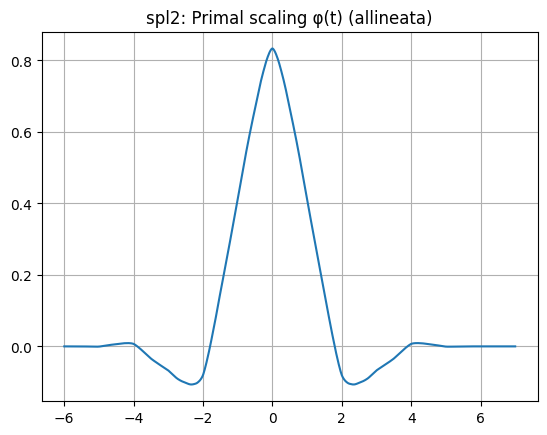

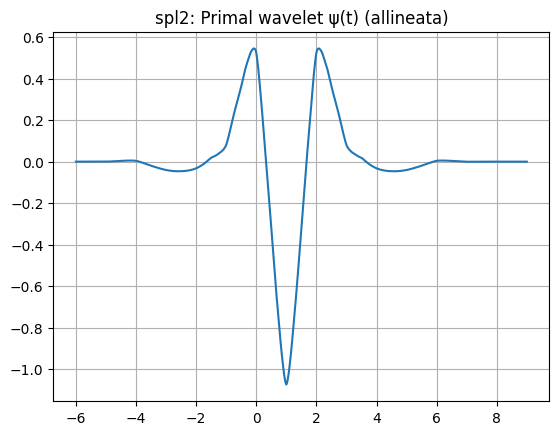

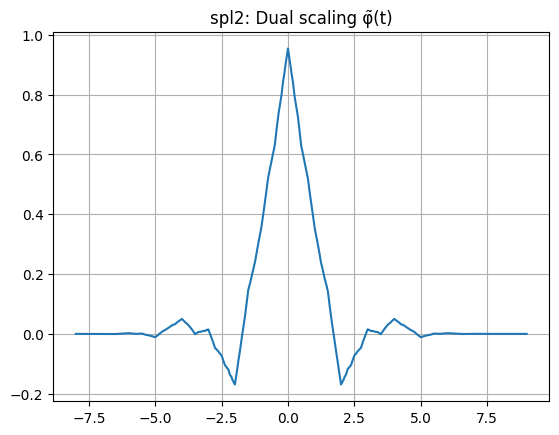

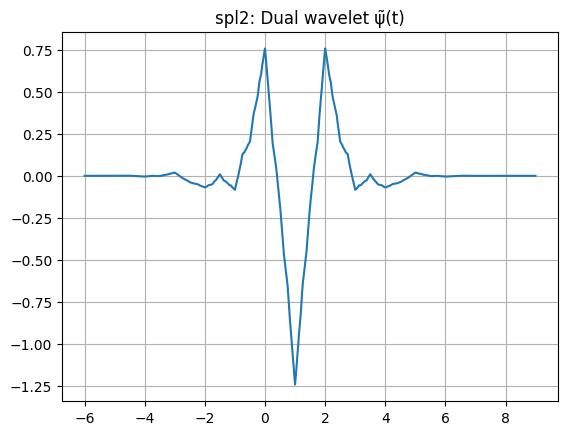

=== Biortogonalità (con tempi reali) ===

<phi(t-k), phi~(t)>
  k=-6: -0.000000
  k=-5: +0.023705
  k=-4: +0.000000
  k=-3: -0.118523
  k=-2: +0.000000
  k=-1: +0.592615
  k= 0: +0.990755
  k= 1: +0.592615
  k= 2: +0.000000
  k= 3: -0.118523
  k= 4: +0.000000
  k= 5: +0.023705
  k= 6: -0.000000

<psi(t-k), psi~(t)>
  k=-6: -0.000000
  k=-5: -0.023098
  k=-4: +0.000000
  k=-3: +0.115490
  k=-2: +0.000000
  k=-1: -0.577450
  k= 0: +0.965402
  k= 1: -0.577450
  k= 2: +0.000000
  k= 3: +0.115490
  k= 4: +0.000000
  k= 5: -0.023098
  k= 6: -0.000000

<phi(t-k), psi~(t)> (atteso ~0)
  k=-6: +0.000000
  k=-5: +0.004076
  k=-4: -0.000000
  k=-3: -0.054425
  k=-2: +0.000000
  k=-1: +0.181019
  k= 0: -0.000000
  k= 1: -0.261339
  k= 2: -0.000000
  k= 3: +0.181019
  k= 4: +0.000000
  k= 5: -0.054425
  k= 6: -0.000000

<psi(t-k), phi~(t)> (atteso ~0)
  k=-6: -0.000000
  k=-5: -0.092622
  k=-4: +0.000000
  k=-3: +0.314232
  k=-2: -0.000000
  k=-1: -0.457898
  k= 0: -0.000000
  k= 1: +0.314232
  k= 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat


# =========================
#  Loader: coeff + asse tap
# =========================
def coeff_and_tau(matvar):
    """
    matvar è una variabile MATLAB 2xN:
      riga 0 -> coefficienti
      riga 1 -> asse temporale (tau) dei tap
    """
    A = np.asarray(matvar, dtype=float)
    if A.ndim != 2 or A.shape[0] != 2:
        raise ValueError(f"Atteso 2xN, trovato {A.shape}")

    c = A[0, :].ravel()
    tau = A[1, :].ravel()

    # controllo passo uniforme (tipicamente 1)
    if len(tau) >= 2:
        d = np.diff(tau)
        if not np.allclose(d, d[0]):
            raise ValueError("Tau dei tap non uniforme: non posso propagare i tempi correttamente.")
    return c, tau


def load_filtri_mat(mat_path, family="spl2", use_t=False):
    """
    Nomi disponibili (tuoi):
      spl2AH, spl2AHt, spl2AL, spl2SH, spl2SHt, spl2SL
      villAH, villAL, villSH, villSL

    Convenzione:
      A = analysis (decomposizione)  -> dual
      S = synthesis (ricostruzione) -> primal
      L = low-pass, H = high-pass

    Ritorna:
      (LoD,tLoD), (HiD,tHiD), (LoR,tLoR), (HiR,tHiR)
    """
    d = loadmat(mat_path)

    def get(name):
        if name not in d:
            keys = [k for k in d.keys() if not k.startswith("__")]
            raise KeyError(f"Variabile '{name}' non trovata. Disponibili: {keys}")
        return coeff_and_tau(d[name])

    if family not in ("spl2", "vill"):
        raise ValueError("family deve essere 'spl2' oppure 'vill'.")

    # analysis = decomposizione (dual)
    LoD, tLoD = get(f"{family}AL")
    if use_t and f"{family}AHt" in d:
        HiD, tHiD = get(f"{family}AHt")
    else:
        HiD, tHiD = get(f"{family}AH")

    # synthesis = ricostruzione (primal)
    LoR, tLoR = get(f"{family}SL")
    if use_t and f"{family}SHt" in d:
        HiR, tHiR = get(f"{family}SHt")
    else:
        HiR, tHiR = get(f"{family}SH")

    return (LoD, tLoD), (HiD, tHiD), (LoR, tLoR), (HiR, tHiR)


# =========================
#  Utility
# =========================
def dyadup(x):
    y = np.zeros(2 * len(x), dtype=float)
    y[0::2] = np.asarray(x, dtype=float).ravel()
    return y


def l2_normalize(x, dt):
    nrm = np.sqrt(np.sum(x**2) * dt)
    return x / nrm if nrm > 0 else x


# =========================
#  Cascade con tempi (tau)
# =========================
def cascade_with_tau(n, lo, tau_lo, hi, tau_hi, normalize_l2=True):
    """
    Cascade stile laboratorio: ad ogni iterazione:
      upsample (dt dimezza) -> conv con lo (low-pass)

    Propagazione tempi:
      - all'inizio: dt = 1 (unità di tau)
      - t0 iniziale di un segnale: tau_min * dt
      - upsample: dt -> dt/2 (t0 invariato)
      - convoluzione: t0_out = t0_in + tau_lo[0] * dt
        (perché il primo tap del filtro parte a tau_lo[0])

    Ritorna:
      phi, psi, t_phi, t_psi, dt, t0_phi, t0_psi
    """
    lo = np.asarray(lo, dtype=float).ravel()
    hi = np.asarray(hi, dtype=float).ravel()
    tau_lo = np.asarray(tau_lo, dtype=float).ravel()
    tau_hi = np.asarray(tau_hi, dtype=float).ravel()

    dt = 1.0
    phi = lo.copy()
    psi = hi.copy()

    # origine temporale dei seed
    t0_phi = tau_lo[0] * dt
    t0_psi = tau_hi[0] * dt

    for _ in range(n):
        # upsample
        phi_u = dyadup(phi)
        psi_u = dyadup(psi)
        dt *= 0.5  # griglia più fine

        # conv con low-pass lo (raffinamento)
        phi = np.convolve(phi_u, lo, mode="full")
        psi = np.convolve(psi_u, lo, mode="full")

        # aggiorna origine temporale dopo convoluzione
        t0_phi = t0_phi + tau_lo[0] * dt
        t0_psi = t0_psi + tau_lo[0] * dt

    if normalize_l2:
        phi = l2_normalize(phi, dt)
        psi = l2_normalize(psi, dt)

    t_phi = t0_phi + np.arange(len(phi)) * dt
    t_psi = t0_psi + np.arange(len(psi)) * dt
    return phi, psi, t_phi, t_psi, dt, t0_phi, t0_psi


# =========================
#  Prodotti interni con t0/dt
# =========================
def inner_product_same_dt(a, t0a, b, t0b, dt):
    """
    <a,b> = ∫ a(t)b(t) dt ~ sum a[i] b[j] dt
    allineando le griglie tramite t = t0 + i*dt.
    """
    ta_min = t0a
    ta_max = t0a + (len(a) - 1) * dt
    tb_min = t0b
    tb_max = t0b + (len(b) - 1) * dt

    t_start = max(ta_min, tb_min)
    t_end = min(ta_max, tb_max)
    if t_end < t_start:
        return 0.0

    ia0 = int(round((t_start - t0a) / dt))
    ib0 = int(round((t_start - t0b) / dt))
    n_overlap = int(round((t_end - t_start) / dt)) + 1

    a_seg = a[ia0:ia0 + n_overlap]
    b_seg = b[ib0:ib0 + n_overlap]
    n = min(len(a_seg), len(b_seg))
    if n <= 0:
        return 0.0
    return float(np.dot(a_seg[:n], b_seg[:n]) * dt)


def biorth_values(phi, t0_phi, phi_t, t0_phi_t, dt, max_k=8):
    """
    Calcola v[k] = <phi(t-k), phi~(t)> = <phi con t0=t0_phi+k, phi_t con t0=t0_phi_t>.
    """
    vals = {}
    for k in range(-max_k, max_k + 1):
        vals[k] = inner_product_same_dt(phi, t0_phi + k, phi_t, t0_phi_t, dt)
    return vals


def argmax_abs(d):
    return max(d.keys(), key=lambda k: abs(d[k]))


def align_primal_to_dual(phi, t0_phi, phi_t, t0_phi_t, psi, t0_psi, psi_t, t0_psi_t, dt, search_k=8):
    """
    Allinea l'origine del PRIMAL (phi,psi) rispetto al DUAL (phi~,psi~)
    in modo che il picco cada a k=0.
    """
    vphi = biorth_values(phi, t0_phi, phi_t, t0_phi_t, dt, max_k=search_k)
    vpsi = biorth_values(psi, t0_psi, psi_t, t0_psi_t, dt, max_k=search_k)

    k0_phi = argmax_abs(vphi)
    k0_psi = argmax_abs(vpsi)

    # Se il picco è a k=k0, allora per portarlo a 0 basta fare t0 += k0
    t0_phi_al = t0_phi + k0_phi
    t0_psi_al = t0_psi + k0_psi

    return (t0_phi_al, k0_phi, vphi), (t0_psi_al, k0_psi, vpsi)


def check_biorth(phi, t0_phi, phi_t, t0_phi_t, psi, t0_psi, psi_t, t0_psi_t, dt, max_k=5):
    print("=== Biortogonalità (con tempi reali) ===")

    print("\n<phi(t-k), phi~(t)>")
    for k in range(-max_k, max_k + 1):
        val = inner_product_same_dt(phi, t0_phi + k, phi_t, t0_phi_t, dt)
        print(f"  k={k:2d}: {val:+.6f}")

    print("\n<psi(t-k), psi~(t)>")
    for k in range(-max_k, max_k + 1):
        val = inner_product_same_dt(psi, t0_psi + k, psi_t, t0_psi_t, dt)
        print(f"  k={k:2d}: {val:+.6f}")

    print("\n<phi(t-k), psi~(t)> (atteso ~0)")
    for k in range(-max_k, max_k + 1):
        val = inner_product_same_dt(phi, t0_phi + k, psi_t, t0_psi_t, dt)
        print(f"  k={k:2d}: {val:+.6f}")

    print("\n<psi(t-k), phi~(t)> (atteso ~0)")
    for k in range(-max_k, max_k + 1):
        val = inner_product_same_dt(psi, t0_psi + k, phi_t, t0_phi_t, dt)
        print(f"  k={k:2d}: {val:+.6f}")


# =========================
#  MAIN
# =========================
if __name__ == "__main__":
    mat_path = "filtri.mat"
    n = 10

    # Scegli famiglia: "spl2" oppure "vill"
    # Se serve prova use_t=True (solo per spl2 perché esistono AHt/SHt)
    family = "spl2"
    use_t = False

    (LoD, tLoD), (HiD, tHiD), (LoR, tLoR), (HiR, tHiR) = load_filtri_mat(mat_path, family=family, use_t=use_t)

    # PRIMAL (synthesis): usa SL/SH
    phi, psi, t_phi, t_psi, dt, t0_phi, t0_psi = cascade_with_tau(
        n, lo=LoR, tau_lo=tLoR, hi=HiR, tau_hi=tHiR, normalize_l2=True
    )

    # DUAL (analysis): usa AL/AH
    phi_t, psi_t, t_phi_t, t_psi_t, dt2, t0_phi_t, t0_psi_t = cascade_with_tau(
        n, lo=LoD, tau_lo=tLoD, hi=HiD, tau_hi=tHiD, normalize_l2=True
    )

    # Verifica "grezza" (può risultare shiftata)
    check_biorth(phi, t0_phi, phi_t, t0_phi_t, psi, t0_psi, psi_t, t0_psi_t, dt, max_k=5)

    # Allineamento automatico (porta il picco a k=0)
    (t0_phi_al, k0_phi, _), (t0_psi_al, k0_psi, _) = align_primal_to_dual(
        phi, t0_phi, phi_t, t0_phi_t, psi, t0_psi, psi_t, t0_psi_t, dt, search_k=8
    )
    print(f"\nAllineamento: phi picco a k={k0_phi}, psi picco a k={k0_psi} -> applico t0_phi += {k0_phi}, t0_psi += {k0_psi}")

    # Plot (con t0 allineati)
    t_phi_al = t0_phi_al + np.arange(len(phi)) * dt
    t_psi_al = t0_psi_al + np.arange(len(psi)) * dt

    plt.figure(); plt.plot(t_phi_al, phi); plt.title(f"{family}: Primal scaling φ(t) (allineata)"); plt.grid(True)
    plt.figure(); plt.plot(t_psi_al, psi); plt.title(f"{family}: Primal wavelet ψ(t) (allineata)"); plt.grid(True)
    plt.figure(); plt.plot(t_phi_t, phi_t); plt.title(f"{family}: Dual scaling φ̃(t)"); plt.grid(True)
    plt.figure(); plt.plot(t_psi_t, psi_t); plt.title(f"{family}: Dual wavelet ψ̃(t)"); plt.grid(True)
    plt.show()

    # Verifica dopo allineamento (picchi a k=0)
    check_biorth(phi, t0_phi_al, phi_t, t0_phi_t, psi, t0_psi_al, psi_t, t0_psi_t, dt, max_k=6)
